# Application: modeling rods with GNNs.

Consider a simply supported rod under uniform vertical load. Create an train a
Convolutional Graph Neural Network model to predict the deformed configuration for a
given load.

1. Generate the a training set of max 1000 samples for different loads
   using the analytical solution obtained from the linear theory:
   - The load should be comprised in the interval $[0, 0.8 \times 10^5]$.
   - The rod should be discretized using 20 points.
   - The length, Young's modulus and moment of inertia of the rod are $1.0$ m, $200$ GPa
     and $10^{-6}$ $\text{m}^4$, respectively.
2. Define a Convolutional Graph Network model and train it. Use part of the training set
   to tune the hyperparameters. Hints:
   - Remember to standardize the training set before training and use the appropriate
     scaling factors when using the network for predictions.
   - For simplicity, do not split the training set in batches. Use the `jraph.batch`
     method to assemble a `GraphsTuple` for the whole training set starting from a _list_
     of `GraphsTuple` objects (one for each sample). The GNN can be then evaluated on the
     whole dataset by passing the assembled `GraphsTuple` to it.
3. Compare the prediction of the deformed configuration for $P = 1.1 \times 10^5$ with the analytical
   solution. 
4. Train a MLP to solve the same task and compare the prediction for the same value of the load with that of the CGN.
5. (Bonus) Consider a non-linear rod model (see lecture 2) to generate the training/test data.
   Repeat steps 2-4.

In [412]:
# Analytical solution for a simply-supported beam under uniform load
def beam_deflection(x, L, w, E, I):
    return (w * L**4 / (24 * E * I)) * ((x / L)**4 - 2 * (x / L)**3 + (x / L)**2)

In [413]:
import numpy as np
import jax.numpy as jnp
import jraph
from jraph import GraphConvolution, GraphMapFeatures
from jax import random
from flax import nnx
import logging
from tqdm.notebook import tqdm # progress bar
import optax
logging.basicConfig(level=logging.INFO)
import matplotlib. pyplot as plt

In [443]:
# Create a simple rod graph
def create_rod_graph(num_nodes, features=None):
    edge_index = [(i, i+1) for i in range(num_nodes-1)] + [(i+1, i) for i in range(num_nodes-1)]

    if features is None:
        features = jnp.ones((num_nodes, 2))

    return jraph.GraphsTuple(n_node=jnp.asarray([num_nodes]),
                             n_edge=jnp.asarray([len(edge_index)]), nodes=features, edges=None, globals=None,
                             senders=jnp.asarray([edge[0] for edge in edge_index]), receivers=jnp.asarray([edge[1] for edge in edge_index]))    

# Generate training and validation sets
def generate_datasets(num_samples, num_nodes, L, E, I):
    x = jnp.linspace(0, L, num_nodes)
    mean_x = jnp.mean(x)
    std_x = jnp.std(x)
    norm_x = (x-mean_x)/std_x

    train_loads = np.linspace(0, 0.8*1e5, num_samples)
    np.random.shuffle(train_loads)
    train_loads = jnp.asarray(train_loads)

    mean_train_loads = jnp.mean(train_loads)
    std_train_loads = jnp.std(train_loads)

    y_train = np.zeros((len(train_loads), num_nodes))
    graphs_list_train = [None]*len(train_loads)

    for i in range(len(train_loads)):
        load_i = train_loads[i]*jnp.ones(num_nodes).reshape(-1,1)
        features = jnp.hstack([(load_i - mean_train_loads)/std_train_loads, norm_x.reshape(-1,1)])
        graphs_list_train[i] = create_rod_graph(num_nodes, features)
        y_train[i] = beam_deflection(x, L, train_loads[i], E, I)
    
    mean_y_train = jnp.mean(y_train)
    std_y_train = jnp.std(y_train)
    y_train = jnp.asarray((y_train-mean_y_train)/std_y_train)

    num_samples_train = int(0.9*len(y_train))
    y_val = y_train[num_samples_train:]
    y_train = y_train[:num_samples_train]

    graphs_list_val = graphs_list_train[num_samples_train:]
    graphs_list_train = graphs_list_train[:num_samples_train]

    return jraph.batch(graphs_list_train), jraph.batch(graphs_list_val), y_train, y_val, mean_y_train, std_y_train, mean_train_loads, std_train_loads


In [444]:
num_nodes = 20
num_samples = 1000
L = 1.0  # Length of the beam
E = 200e9  # Modulus of Elasticity (Pa) for steel
I = 1e-6  # Moment of inertia (m^4)

graphs_train, graphs_val, y_train, y_val, mean_y_train, std_y_strain, mean_train_loads, std_train_loads = generate_datasets(num_samples, num_nodes, L, E, I)

In [458]:
# Could be used to update node features (not used at the moment)
class MLP(nnx.Module):
  def __init__(self, in_features, out_features, rngs: nnx.Rngs):
    self.layers = []
    self.layers.append(nnx.Linear(in_features, 2*in_features, rngs=rngs))
    self.layers.append(nnx.relu)
    self.layers.append(nnx.Linear(2*in_features, out_features, rngs=rngs))

  def __call__(self, x):
    y = x
    for layer in self.layers:
      y = layer(y)
    return y

# Use MLP block to define the update node function
update_node_fn_1 = lambda x: MLP(in_features=2, out_features=16, rngs=nnx.Rngs(0))(x)
update_node_fn_2 = lambda x: MLP(in_features=16, out_features=16, rngs=nnx.Rngs(0))(x)
update_node_fn_3 = lambda x: MLP(in_features=16, out_features=11, rngs=nnx.Rngs(0))(x)

In [485]:
class GCN(nnx.Module):
  def __init__(self, in_features, hidden_channels, rngs: nnx.Rngs):
    # self.layer1 = nnx.Linear(in_features, hidden_channels, rngs=rngs)
    self.update_node_fn_1 = MLP(in_features=2, out_features=hidden_channels, rngs=nnx.Rngs(0))
    self.layer2 = nnx.Linear(hidden_channels, hidden_channels, rngs=rngs)
    self.layer3 = nnx.Linear(hidden_channels, 1, rngs=rngs)

  def __call__(self, graph):
    self._gn1 = GraphConvolution(update_node_fn=lambda x: self.update_node_fn_1(x))
    self._gn2 = GraphConvolution(update_node_fn=lambda x: nnx.relu(self.layer2(x)),
                                add_self_edges=True)
    self._gn3 = GraphConvolution(update_node_fn=self.layer3, add_self_edges=True)
    y = self._gn1(graph)
    y = self._gn2(y)
    y = self._gn3(y)
    return y.nodes

In [498]:
@nnx.jit
def loss_fn(model, graph, labels):
    output_graph_nodes = model(graph)
    loss = optax.losses.l2_loss(output_graph_nodes.reshape(labels.shape), labels)
    return jnp.mean(loss) + 100*((std_y_strain*output_graph_nodes[0,0]+mean_y_train)**2 + (std_y_strain*output_graph_nodes[-1,0]+mean_y_train)**2)

# Train for a single epoch
@nnx.jit
def train_step(model, optimizer, graph_batch, labels):
    loss, grads = nnx.value_and_grad(loss_fn)(model, graph_batch, labels)
    optimizer.update(grads)
    return loss

def _train_epoch(model, optimizer, graphs_train, graphs_val, y_train, y_val):
    valid_loss = None

    train_loss = np.mean(train_step(model, optimizer, graphs_train, y_train))

    if graphs_val is not None:
        valid_loss = loss_fn(model, graphs_val, y_val)

    return model, train_loss, valid_loss


def train(model, optimizer, graphs_train, y_train, epochs,
          graphs_val=None, y_val=None, log_period_epoch=1, show_progress=True):

    train_loss_history = []

    for epoch in tqdm(range(1, epochs + 1), disable=not show_progress):
        model, train_loss, valid_loss = _train_epoch(
            model, optimizer, graphs_train, graphs_val, y_train, y_val)

        train_loss_history.append(train_loss)

        if epoch == 1 or epoch % log_period_epoch == 0:
            if graphs_val is not None:
                logging.info(
                    "epoch:% 3d, train_loss: %.4f, valid_loss: %.4f"
                    % (epoch, train_loss, valid_loss)
                )
            else:
                logging.info(
                    "epoch:% 3d, train_loss: %.4f"
                    % (epoch, train_loss)
                )
    return train_loss_history

In [499]:
hidden_channels = 16
gcn = GCN(2, hidden_channels, nnx.Rngs(0))

# Define the optimizer
lr = 1e-2 # learning rate
optimizer = nnx.Optimizer(gcn, optax.adam(lr)) # Adam optimizer

epochs = 1000

train_loss_history = train(gcn, optimizer, graphs_train, y_train, epochs, graphs_val=graphs_val, y_val=y_val, log_period_epoch=10, show_progress=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:epoch:  1, train_loss: 0.4272, valid_loss: 0.3346
INFO:root:epoch: 10, train_loss: 0.1635, valid_loss: 0.1514
INFO:root:epoch: 20, train_loss: 0.0662, valid_loss: 0.0553
INFO:root:epoch: 30, train_loss: 0.0319, valid_loss: 0.0326
INFO:root:epoch: 40, train_loss: 0.0280, valid_loss: 0.0270
INFO:root:epoch: 50, train_loss: 0.0202, valid_loss: 0.0195
INFO:root:epoch: 60, train_loss: 0.0179, valid_loss: 0.0171
INFO:root:epoch: 70, train_loss: 0.0163, valid_loss: 0.0157
INFO:root:epoch: 80, train_loss: 0.0149, valid_loss: 0.0143
INFO:root:epoch: 90, train_loss: 0.0139, valid_loss: 0.0135
INFO:root:epoch: 100, train_loss: 0.0132, valid_loss: 0.0128
INFO:root:epoch: 110, train_loss: 0.0125, valid_loss: 0.0122
INFO:root:epoch: 120, train_loss: 0.0118, valid_loss: 0.0116
INFO:root:epoch: 130, train_loss: 0.0112, valid_loss: 0.0112
INFO:root:epoch: 140, train_loss: 0.0107, valid_loss: 0.0107
INFO:root:epoch: 150, train_loss: 0.0101, valid_loss: 0.0102
INFO:root:epoch: 160, train_loss: 

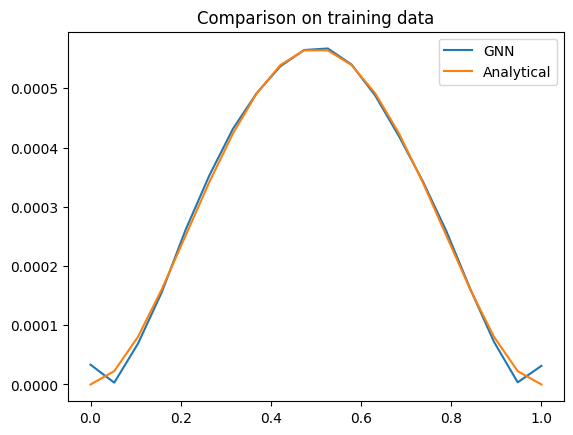

In [502]:
graphs_train_lst = jraph.unbatch(graphs_train)
id = 300
pred = std_y_strain*gcn(graphs_train_lst[id])+mean_y_train
x = jnp.linspace(0, L, num_nodes)
plt.plot(x, pred, label="GNN")
plt.plot(x, std_y_strain*y_train[id]+mean_y_train, label="Analytical")
plt.title("Comparison on training data")
plt.legend()
plt.show()

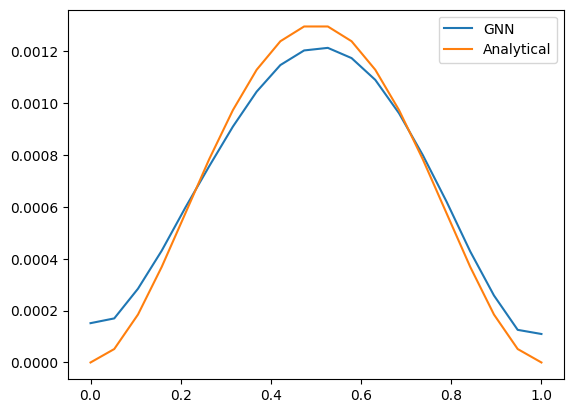

In [504]:
test_load = 1e5
norm_load = (test_load*jnp.ones(num_nodes).reshape(-1,1)-mean_train_loads)/std_train_loads
x = jnp.linspace(0, L, num_nodes)
mean_x = jnp.mean(x)
std_x = jnp.std(x)
norm_x = (x-mean_x)/std_x
features = jnp.hstack([norm_load, norm_x.reshape(-1,1)])
graph = create_rod_graph(num_nodes, features)
pred = std_y_strain*gcn(graph)+mean_y_train
y_theory = beam_deflection(x, L, test_load, E, I)
plt.plot(x, pred, label="GNN")
plt.plot(x, y_theory, label="Analytical")
plt.legend()
plt.show()